Putting code from https://adventuresinmachinelearning.com/reinforcement-learning-tensorflow/ on notebook

In [17]:
!pip install tensorflow
!pip install gym

In [0]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import random
import math
from numpy import linalg as LA
import copy

In [0]:
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.0001
GAMMA = 0.99
BATCH_SIZE = 50

Our code

In [0]:
class Particle(object):
    default_fuel = 100

    def __init__(self,
                 id,
                 mass,
                 initial_time=0,
                 initial_position=None,
                 initial_velocity=None,
                 initial_fuel=default_fuel,
                 exhaust_velocity = None):

        self.id = id  # Particle's UID
        self.mass = mass  # Particle's mass in kilograms
        self.exhaust_velocity = exhaust_velocity
        if initial_position is None:
            initial_position = np.zeros((2, 1))

        if initial_velocity is None:
            initial_velocity = np.zeros((2, 1))
            
        if self.exhaust_velocity is None:
            self.exhaust_velocity = 0

        '''
        List of instantaneous particle states. Each particle state is a tuple
        with the following structure: (time, location, velocity, fuel_weight)
        The dimensions of each of the entries in the tuple are as follows:
        time -> seconds
        location -> n-dimensional numpy vector - meters^2
        velocity -> n-dimensional numpy vector - (meters/second)^2
        fuel_weight -> scalar - kilograms
       '''
        self.state_list = [
            (initial_time, initial_position, initial_velocity, initial_fuel)
        ]

    def current_position(self):
        return self.state_list[-1][1]

    def current_state(self):
        return self.state_list[-1][1:]

    def step(self, update_function, thrust, step_length):
        new_state = update_function(self, thrust, step_length)
        self.state_list.append(new_state)
        reward = self.get_reward()
        done = self.is_done()
        log = "TODO add logging"
        return new_state, reward, done, log

    def is_done(self):
        return False

    def get_reward(self):
        return -1


class Scene(object):
    def __init__(self, particle_list, update_functions, step_length, target, global_start_time=0):
        self.init_particles = particle_list

        self.particle_list = copy.deepcopy(particle_list)

        self.ship = self.particle_list[0]

        self.target = target

        # How each of the particles' position is to be updated
        self.update_functions = update_functions
        self.step_length = step_length

        #params
        self.action_list = [(0, 0), (1, 0), (1, np.pi), (1, np.pi/2), (1, np.pi * 3 / 2)]
        self.max_steps = 200
        self.steps_taken = 0
        self.goal_dist = .1

    def reset(self):
        self.steps_taken = 0
        self.particle_list = copy.deepcopy(self.init_particles)
        self.ship = self.particle_list[0]
        return self.get_next_state()

    def get_positions(self):
        return [tuple(p.current_position().flatten()) for p in self.particle_list]

    def old_step(self, input_thrusts):
        for (particle, update_function, thrust) in \
                zip(self.particle_list, self.update_functions, input_thrusts):

            particle.step(update_function, thrust, self.step_length)
        self.steps_taken += 1
        reward = self.get_reward()
        done = self.is_done()
        log = "TODO do log"
        return self.get_positions(), reward, done, log

    def step(self, action):
      #action is a number 0-4
      # 0 - do nothing
      # 1/2 -  +/- x
      # 3/4 -  +/- y
      input_thrusts = [(0,0) for x in range(len(self.particle_list))]
      input_thrusts[0] = self.action_list[action]
      for (particle, update_function, thrust) in \
                zip(self.particle_list, self.update_functions, input_thrusts):

            particle.step(update_function, thrust, self.step_length)
      self.steps_taken += 1
      next_step = self.get_next_state()
      reward = self.get_reward()
      done = self.is_done()
      log = "TODO do log"
      
      return next_step, reward, done, log


    def get_next_state(self):
        current_state = self.ship.current_state()
        return np.array([current_state[0][0], current_state[0][1], current_state[1][0], current_state[1][1], current_state[2]])

    def is_done(self):
        return LA.norm(self.target - self.ship.current_position()) < self.goal_dist or self.max_steps <= self.steps_taken


    def get_distance_to_goal(self):
        return LA.norm(self.target - self.ship.current_position())

    def get_reward(self):
        distance = self.get_distance_to_goal()
        if distance < self.goal_dist:
            reward = 10000
        elif distance < .5:
            reward = 20
        elif distance < 1:
            reward = 10
        else:
            reward = 0
        return reward - 1

In [0]:
K = 9.81


def zero_update_function(particle, thrust, step_length):
    state = list(particle.state_list[-1])
    state[0] += step_length
    return tuple(state)


def gravitaional_pull_from_list(particle_list):
    def update_function(particle, thrust, step_length):
        net_f = np.zeros((2, 1))
        time, position, velocity, fuel = particle.state_list[-1]
        m0 = (fuel + particle.mass)
        for p in particle_list:
            if p.id != particle.id:
                distance_p = position - p.current_position()
                force_p = - ((K * m0 * p.mass)/(LA.norm(distance_p)
                                                           ** 2)) * (distance_p/LA.norm(distance_p))
                net_f += force_p

        # Add Thrust Logic Here #
        mag_thrust, dir_thrust = thrust
        
        if mag_thrust > fuel:
            mag_thrust = fuel
        dv_thrust = particle.exhaust_velocity*np.log(m0/(m0 - mag_thrust))
        
        dv_thrust = np.array([dv_thrust* np.cos(dir_thrust), dv_thrust* np.sin(dir_thrust)]).reshape((2,1))
        #########################
        net_a = net_f/m0
        dv = net_a * step_length
        avg_v = velocity + .5 * dv + dv_thrust
        next_time = time + step_length
        next_position = position + avg_v * step_length
        next_velocity = velocity + dv + dv_thrust
        next_fuel = fuel - mag_thrust

        return (next_time, next_position, next_velocity, next_fuel)
    return update_function

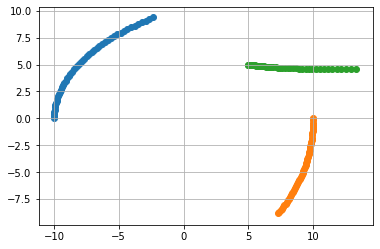

In [41]:
p1_position = np.array([-10, 0]).reshape((2, 1))
p1_velocity = np.array([0, 2]).reshape((2, 1))
p1 = Particle(1, 10, initial_position=p1_position,
              initial_velocity=p1_velocity)


p2_position = np.array([10, 0]).reshape((2, 1))
p2_velocity = np.array([0, -2]).reshape((2, 1))
p2 = Particle(2, 10, initial_position=p2_position,
              initial_velocity=p2_velocity)

p3_position = np.array([5, 5]).reshape((2, 1))
p3_velocity = np.array([0, 0]).reshape((2, 1))
p3 = Particle(2, 10, initial_position=p3_position,
              initial_velocity=p3_velocity, exhaust_velocity=10)


# Setting Scene #
step_size = 0.1
particle_list = [p1, p2, p3]
update_function = gravitaional_pull_from_list(particle_list)
scene = Scene(particle_list, [
              update_function for p in particle_list], step_size, np.zeros((2,1)))

# Simmulate positions
position_list = []
for _ in range(10 * 5):
    positions = scene.get_positions()
    position_list.append(positions)
    scene.step([(1, np.pi/1000)]*len(particle_list))


paths = list(zip(*position_list))
for path in paths:
    plt.scatter(*zip(*path))

plt.grid(True)
plt.show()

Create model

In [0]:
class Model:
    def __init__(self, num_states, num_actions, batch_size):
        self._num_states = num_states
        self._num_actions = num_actions
        self._batch_size = batch_size
        # define the placeholders
        self._states = None
        self._actions = None
        # the output operations
        self._logits = None
        self._optimizer = None
        self._var_init = None
        # now setup the model
        self._define_model()

    def _define_model(self):
        self._states = tf.placeholder(shape=[None, self._num_states], dtype=tf.float32)
        self._q_s_a = tf.placeholder(shape=[None, self._num_actions], dtype=tf.float32)
        # create a couple of fully connected hidden layers
        fc1 = tf.layers.dense(self._states, 50, activation=tf.nn.relu)
        fc2 = tf.layers.dense(fc1, 50, activation=tf.nn.relu)
        self._logits = tf.layers.dense(fc2, self._num_actions)
        loss = tf.losses.mean_squared_error(self._q_s_a, self._logits)
        self._optimizer = tf.train.AdamOptimizer().minimize(loss)
        self._var_init = tf.global_variables_initializer()

    def predict_one(self, state, sess):
        return sess.run(self._logits, feed_dict={self._states:
                                                     state.reshape(1, self.num_states)})

    def predict_batch(self, states, sess):
        return sess.run(self._logits, feed_dict={self._states: states})

    def train_batch(self, sess, x_batch, y_batch):
        sess.run(self._optimizer, feed_dict={self._states: x_batch, self._q_s_a: y_batch})

    @property
    def num_states(self):
        return self._num_states

    @property
    def num_actions(self):
        return self._num_actions

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def var_init(self):
        return self._var_init

Create Memory Class

In [0]:
class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

In [0]:
Create Runner Class

In [0]:
class GameRunner:
    def __init__(self, sess, model, env, memory, max_eps, min_eps,
                 decay, render=True):
        self._sess = sess
        self._env = env
        self._model = model
        self._memory = memory
        self._render = render
        self._max_eps = max_eps
        self._min_eps = min_eps
        self._decay = decay
        self._eps = self._max_eps
        self._steps = 0
        self._reward_store = []
        self._max_x_store = []

    def run(self):
        state = self._env.reset()
        tot_reward = 0
        max_x = 100
        while True:
            if self._render:
                self._env.render()

            action = self._choose_action(state)
            next_state, reward, done, info = self._env.step(action)

            if self._env.get_distance_to_goal() < max_x:
                max_x = self._env.get_distance_to_goal()
            # is the game complete? If so, set the next state to
            # None for storage sake
            if done:
                next_state = None

            self._memory.add_sample((state, action, reward, next_state))
            self._replay()

            # exponentially decay the eps value
            self._steps += 1
            self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) \
                                      * math.exp(-LAMBDA * self._steps)

            # move the agent to the next state and accumulate the reward
            state = next_state
            tot_reward += reward

            # if the game is done, break the loop
            if done:
                self._reward_store.append(tot_reward)
                self._max_x_store.append(max_x)
                break

        print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))

    def _choose_action(self, state):
        if random.random() < self._eps:
            return random.randint(0, self._model.num_actions - 1)
        else:
            return np.argmax(self._model.predict_one(state, self._sess))

    def _replay(self):
        batch = self._memory.sample(self._model.batch_size)
        states = np.array([val[0] for val in batch])
        next_states = np.array([(np.zeros(self._model.num_states)
                                 if val[3] is None else val[3]) for val in batch])
        # predict Q(s,a) given the batch of states
        q_s_a = self._model.predict_batch(states, self._sess)
        # predict Q(s',a') - so that we can do gamma * max(Q(s'a')) below
        q_s_a_d = self._model.predict_batch(next_states, self._sess)
        # setup training arrays
        x = np.zeros((len(batch), self._model.num_states))
        y = np.zeros((len(batch), self._model.num_actions))
        for i, b in enumerate(batch):
            state, action, reward, next_state = b[0], b[1], b[2], b[3]
            # get the current q values for all actions in state
            current_q = q_s_a[i]
            # update the q value for action
            if next_state is None:
                # in this case, the game completed after action, so there is no max Q(s',a')
                # prediction possible
                current_q[action] = reward
            else:
                current_q[action] = reward + GAMMA * np.amax(q_s_a_d[i])
            x[i] = state
            y[i] = current_q
        self._model.train_batch(self._sess, x, y)
    
    def get_ship_list(self):
        return self._env.ship.state_list

    @property
    def reward_store(self):
        return self._reward_store

    @property
    def max_x_store(self):
        return self._max_x_store

Run with Main

Episode 1 of 300


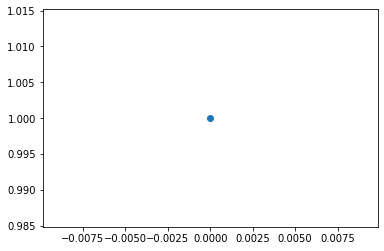

Step 200, Total reward: 1270, Eps: 0.9803966865736877
Step 400, Total reward: 1070, Eps: 0.9611815447608
Step 600, Total reward: 90, Eps: 0.9423468882484062
Step 800, Total reward: 1080, Eps: 0.9238851829227694
Step 1000, Total reward: 790, Eps: 0.9057890438555999
Step 1200, Total reward: 1320, Eps: 0.888051232349986
Step 1400, Total reward: 1670, Eps: 0.8706646530448178
Step 1600, Total reward: 1850, Eps: 0.8536223510765493
Step 1800, Total reward: 1460, Eps: 0.8369175092971592
Step 2000, Total reward: 1360, Eps: 0.820543445547202
Episode 11 of 300


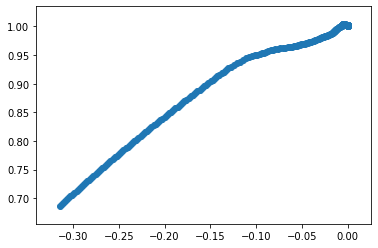

Step 2200, Total reward: 1680, Eps: 0.8044936099828537
Step 2400, Total reward: 1610, Eps: 0.7887615824558878
Step 2600, Total reward: 1440, Eps: 0.7733410699455306
Step 2800, Total reward: 1690, Eps: 0.7582259040411682
Step 3000, Total reward: 1460, Eps: 0.7434100384749007
Step 3200, Total reward: 1390, Eps: 0.7288875467029541
Step 3400, Total reward: 2190, Eps: 0.7146526195349836
Step 3600, Total reward: 1500, Eps: 0.7006995628103208
Step 3800, Total reward: 1360, Eps: 0.6870227951202322
Step 4000, Total reward: 1770, Eps: 0.6736168455752829
Episode 21 of 300


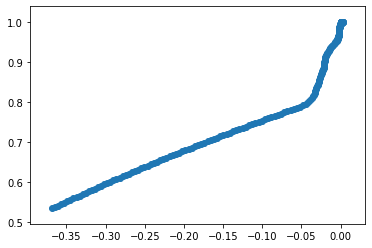

Step 4200, Total reward: 1400, Eps: 0.6604763516169062
Step 4400, Total reward: 2030, Eps: 0.64759605687231
Step 4600, Total reward: 2130, Eps: 0.6349708090518567
Step 4800, Total reward: 1690, Eps: 0.6225955578880794
Step 5000, Total reward: 1770, Eps: 0.6104653531155071
Step 5200, Total reward: 1790, Eps: 0.5985753424904925
Step 5400, Total reward: 1270, Eps: 0.5869207698502498
Step 5600, Total reward: 1560, Eps: 0.5754969732103268
Step 5800, Total reward: 1450, Eps: 0.564299382899748
Step 6000, Total reward: 1420, Eps: 0.5533235197330861
Episode 31 of 300


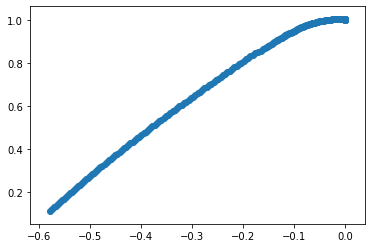

Step 6200, Total reward: 1570, Eps: 0.5425649932187278
Step 6400, Total reward: 1400, Eps: 0.5320194998026181
Step 6600, Total reward: 1590, Eps: 0.5216828211467822
Step 6800, Total reward: 1590, Eps: 0.5115508224419336
Step 7000, Total reward: 1700, Eps: 0.5016194507534953
Step 7200, Total reward: 1250, Eps: 0.4918847334003719
Step 7400, Total reward: 1770, Eps: 0.48234277636582407
Step 7600, Total reward: 1550, Eps: 0.47298976273981014
Step 7800, Total reward: 1580, Eps: 0.4638219511921713
Step 8000, Total reward: 1600, Eps: 0.45483567447604933
Episode 41 of 300


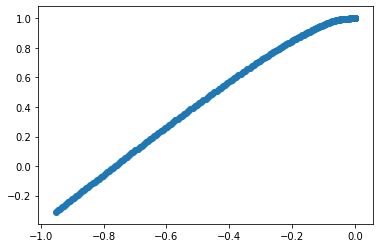

Step 8200, Total reward: 1450, Eps: 0.44602733796093924
Step 8400, Total reward: 1720, Eps: 0.4373934181947889
Step 8600, Total reward: 1550, Eps: 0.4289304614945713
Step 8800, Total reward: 1150, Eps: 0.42063508256476556
Step 9000, Total reward: -200, Eps: 0.4125039631431931
Step 9200, Total reward: -200, Eps: 0.404533850673669
Step 9400, Total reward: -200, Eps: 0.3967215570049359
Step 9600, Total reward: -200, Eps: 0.3890639571153609
Step 9800, Total reward: -200, Eps: 0.38155798786288553
Step 10000, Total reward: -200, Eps: 0.3742006467597279
Episode 51 of 300


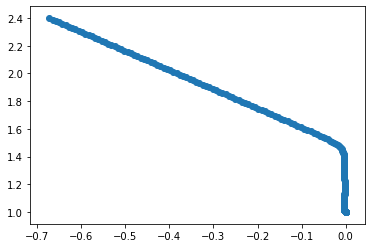

Step 10200, Total reward: -200, Eps: 0.3669889907713475
Step 10400, Total reward: -200, Eps: 0.35992013513919235
Step 10600, Total reward: -200, Eps: 0.3529912522267568
Step 10800, Total reward: -200, Eps: 0.34619957038848975
Step 11000, Total reward: -200, Eps: 0.3395423728610988
Step 11200, Total reward: -200, Eps: 0.33301699667680906
Step 11400, Total reward: -200, Eps: 0.3266208315981408
Step 11600, Total reward: -200, Eps: 0.32035131907377923
Step 11800, Total reward: 110, Eps: 0.3142059512151199
Step 12000, Total reward: -200, Eps: 0.3081822697930801
Episode 61 of 300


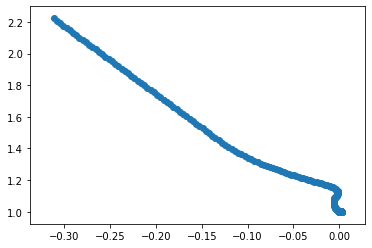

Step 12200, Total reward: -200, Eps: 0.30227786525477407
Step 12400, Total reward: 210, Eps: 0.29649037575966014
Step 12600, Total reward: -200, Eps: 0.2908174862347727
Step 12800, Total reward: -200, Eps: 0.2852569274486622
Step 13000, Total reward: 400, Eps: 0.27980647510367246
Step 13200, Total reward: -200, Eps: 0.27446394894619186
Step 13400, Total reward: -200, Eps: 0.26922721189452276
Step 13600, Total reward: -200, Eps: 0.26409416918402034
Step 13800, Total reward: -200, Eps: 0.2590627675291589
Step 14000, Total reward: -200, Eps: 0.2541309943021904
Episode 71 of 300


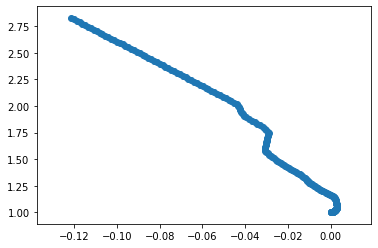

Step 14200, Total reward: -200, Eps: 0.24929687672806605
Step 14400, Total reward: -200, Eps: 0.2445584810953005
Step 14600, Total reward: -200, Eps: 0.23991391198246126
Step 14800, Total reward: 1600, Eps: 0.2353613114999746
Step 15000, Total reward: -200, Eps: 0.23089885854694553
Step 15200, Total reward: -200, Eps: 0.22652476808269262
Step 15400, Total reward: 230, Eps: 0.22223729041270818
Step 15600, Total reward: -200, Eps: 0.21803471048875708
Step 15800, Total reward: -200, Eps: 0.21391534722283462
Step 16000, Total reward: 270, Eps: 0.20987755281470882
Episode 81 of 300


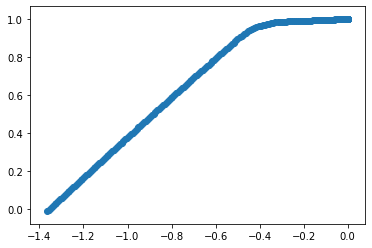

Step 16200, Total reward: -200, Eps: 0.2059197120927785
Step 16400, Total reward: 1310, Eps: 0.20204024186798297
Step 16572, Total reward: 11548, Eps: 0.19876539413388167
Step 16772, Total reward: 660, Eps: 0.1950275888962576
Step 16972, Total reward: 1790, Eps: 0.19136379716125942
Step 17172, Total reward: 2120, Eps: 0.18777255336334195
Step 17372, Total reward: 2250, Eps: 0.18425242095710215
Step 17538, Total reward: 11734, Eps: 0.18138370697023817
Step 17738, Total reward: 1860, Eps: 0.1779900821986212
Step 17938, Total reward: 1980, Eps: 0.17466365569978123
Episode 91 of 300


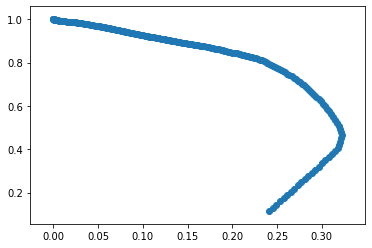

Step 18110, Total reward: 11848, Eps: 0.17185565882104387
Step 18310, Total reward: 2320, Eps: 0.16865070204357802
Step 18510, Total reward: 1890, Eps: 0.1655092076623005
Step 18710, Total reward: 1770, Eps: 0.16242991903757167
Step 18868, Total reward: 11762, Eps: 0.1600404528086422
Step 19002, Total reward: 11426, Eps: 0.15804332140506386
Step 19202, Total reward: 2310, Eps: 0.15511186723316917
Step 19330, Total reward: 11342, Eps: 0.15326627233836485
Step 19462, Total reward: 11238, Eps: 0.1513875841639228
Step 19645, Total reward: 11567, Eps: 0.14882372226071408
Episode 101 of 300


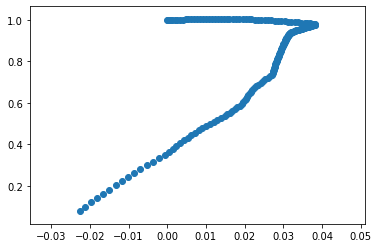

Step 19845, Total reward: 2110, Eps: 0.1460748283834574
Step 19981, Total reward: 11404, Eps: 0.14423673806263548
Step 20181, Total reward: 1920, Eps: 0.1415786725580217
Step 20300, Total reward: 11171, Eps: 0.14002216593700811
Step 20442, Total reward: 11138, Eps: 0.13818889818663585
Step 20642, Total reward: 2020, Eps: 0.13565058793519522
Step 20842, Total reward: 2200, Eps: 0.1331625395942921
Step 20966, Total reward: 11396, Eps: 0.13164475382295038
Step 21166, Total reward: 2160, Eps: 0.12923602631198283
Step 21366, Total reward: 2080, Eps: 0.12687499480137493
Episode 111 of 300


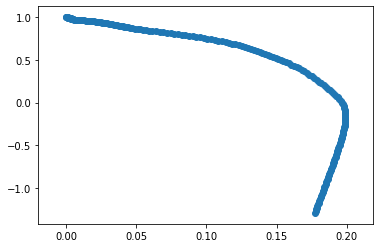

Step 21481, Total reward: 11205, Eps: 0.12553863117979153
Step 21681, Total reward: 1480, Eps: 0.12325081299811015
Step 21881, Total reward: 1850, Eps: 0.121008296651659
Step 22081, Total reward: 1950, Eps: 0.11881018510399888
Step 22281, Total reward: 1890, Eps: 0.11665559908120217
Step 22481, Total reward: 1380, Eps: 0.11454367672013156
Step 22681, Total reward: 2030, Eps: 0.11247357322368327
Step 22881, Total reward: 1830, Eps: 0.11044446052285699
Step 23081, Total reward: 1890, Eps: 0.10845552694551717
Step 23281, Total reward: 1040, Eps: 0.10650597689171343
Episode 121 of 300


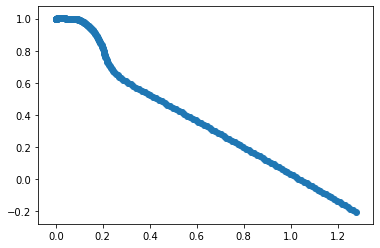

Step 23481, Total reward: 2090, Eps: 0.10459503051542988
Step 23681, Total reward: 1650, Eps: 0.1027219234126364
Step 23812, Total reward: 11349, Eps: 0.10151518759282907
Step 24012, Total reward: 1460, Eps: 0.09970306546590989
Step 24212, Total reward: 2140, Eps: 0.09792682576123389
Step 24412, Total reward: 1920, Eps: 0.0961857579592357
Step 24612, Total reward: -200, Eps: 0.09447916560957995
Step 24812, Total reward: 1320, Eps: 0.09280636605257193
Step 25012, Total reward: 710, Eps: 0.09116669014608454
Step 25212, Total reward: 1820, Eps: 0.08955948199789256
Episode 131 of 300


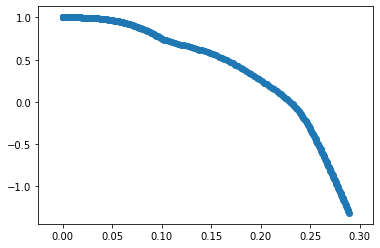

Step 25412, Total reward: 1590, Eps: 0.087984098703307
Step 25612, Total reward: 1590, Eps: 0.08643991008800458
Step 25812, Total reward: 2200, Eps: 0.08492629845594975
Step 26012, Total reward: 1090, Eps: 0.08344265834230792
Step 26212, Total reward: 960, Eps: 0.08198839627125154
Step 26356, Total reward: 11456, Eps: 0.08095919142444083
Step 26556, Total reward: 1750, Eps: 0.07955410529315698
Step 26686, Total reward: 11370, Eps: 0.07865575386040588
Step 26822, Total reward: 11384, Eps: 0.0777283562061981
Step 27022, Total reward: 1960, Eps: 0.07638724489856272
Episode 141 of 300


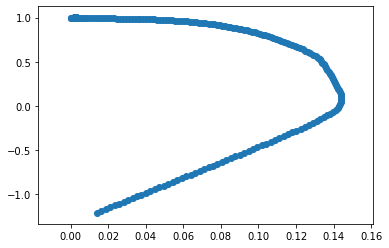

Step 27171, Total reward: 11471, Eps: 0.07540540780069055
Step 27371, Total reward: 1640, Eps: 0.07411029395332418
Step 27571, Total reward: 2080, Eps: 0.07284082507835446
Step 27771, Total reward: 2030, Eps: 0.07159649337130491
Step 27971, Total reward: 1340, Eps: 0.07037680108290145
Step 28171, Total reward: 1920, Eps: 0.06918126031996587
Step 28371, Total reward: 2140, Eps: 0.06800939285025226
Step 28571, Total reward: 1530, Eps: 0.06686072991114765
Step 28715, Total reward: 11166, Eps: 0.06604780252494447
Step 28915, Total reward: 1730, Eps: 0.06493798167670957
Episode 151 of 300


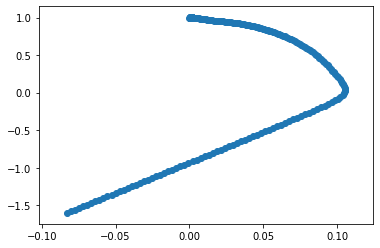

Step 29115, Total reward: 2200, Eps: 0.06385013675366155
Step 29315, Total reward: 2230, Eps: 0.06278383260332639
Step 29515, Total reward: 1840, Eps: 0.061738642689826394
Step 29715, Total reward: 1990, Eps: 0.06071414892326008
Step 29845, Total reward: 11310, Eps: 0.06005913182320623
Step 30045, Total reward: 1710, Eps: 0.059067894599994716
Step 30160, Total reward: 11085, Eps: 0.05850684602461245
Step 30290, Total reward: 11070, Eps: 0.05788033815076684
Step 30460, Total reward: 10910, Eps: 0.05707325207111035
Step 30619, Total reward: 11481, Eps: 0.05633070624600753
Episode 161 of 300


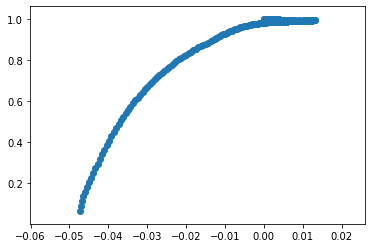

Step 30754, Total reward: 11075, Eps: 0.055709444662755014
Step 30892, Total reward: 11162, Eps: 0.05508298682732774
Step 31092, Total reward: -200, Eps: 0.05419028387685258
Step 31292, Total reward: 1650, Eps: 0.053315257629139794
Step 31492, Total reward: 1940, Eps: 0.05245755806202314
Step 31692, Total reward: 190, Eps: 0.05161684208423961
Step 31892, Total reward: 760, Eps: 0.05079277339818841
Step 32092, Total reward: 1970, Eps: 0.049985022365407375
Step 32292, Total reward: -200, Eps: 0.04919326587471325
Step 32492, Total reward: 1170, Eps: 0.04841718721295286
Episode 171 of 300


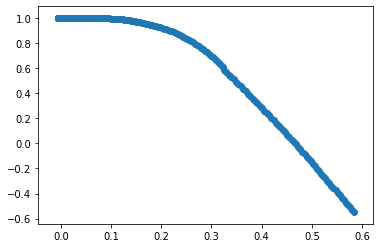

Step 32692, Total reward: 1860, Eps: 0.04765647593831363
Step 32892, Total reward: 2050, Eps: 0.04691082775614277
Step 33092, Total reward: 1720, Eps: 0.04617994439722531
Step 33292, Total reward: 1240, Eps: 0.045463533498472423
Step 33492, Total reward: 2090, Eps: 0.04476130848597234
Step 33692, Total reward: 1230, Eps: 0.04407298846035694
Step 33892, Total reward: 2050, Eps: 0.04339829808443826
Step 34092, Total reward: 790, Eps: 0.042736967473069924
Step 34292, Total reward: 2080, Eps: 0.04208873208518955
Step 34492, Total reward: 1820, Eps: 0.0414533326179987
Episode 181 of 300


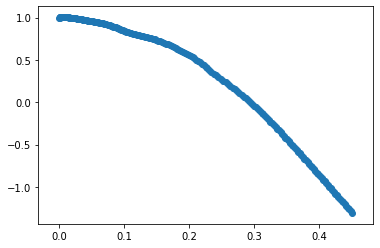

Step 34692, Total reward: 2110, Eps: 0.04083051490323841
Step 34892, Total reward: 1900, Eps: 0.04022002980551844
Step 35092, Total reward: 1720, Eps: 0.039621633122659775
Step 35292, Total reward: 1950, Eps: 0.03903508548801055
Step 35492, Total reward: 1670, Eps: 0.038460152274696166
Step 35692, Total reward: -200, Eps: 0.037896603501765415
Step 35892, Total reward: 640, Eps: 0.03734421374219505
Step 36092, Total reward: 1580, Eps: 0.036802762032715944
Step 36292, Total reward: 2030, Eps: 0.03627203178542484
Step 36492, Total reward: 1670, Eps: 0.03575181070114633
Episode 191 of 300


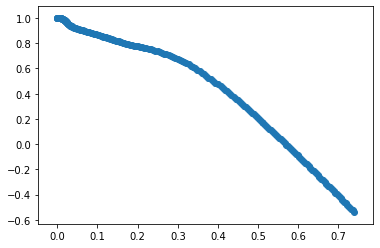

Step 36692, Total reward: 80, Eps: 0.035241890684510335
Step 36844, Total reward: 11268, Eps: 0.034861115171176765
Step 37044, Total reward: 1940, Eps: 0.034368832107713916
Step 37163, Total reward: 11101, Eps: 0.03408056161687658
Step 37363, Total reward: 2220, Eps: 0.033603734549344
Step 37563, Total reward: 2060, Eps: 0.03313634929035182
Step 37763, Total reward: 2040, Eps: 0.03267821887956454
Step 37963, Total reward: 1750, Eps: 0.03222916005870938
Step 38163, Total reward: 2230, Eps: 0.03178899319827044
Step 38363, Total reward: 1930, Eps: 0.03135754222563461
Episode 201 of 300


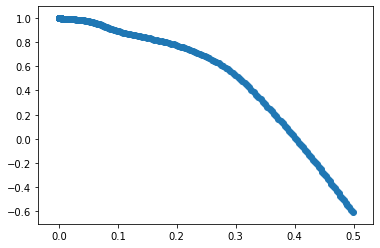

Step 38563, Total reward: 2220, Eps: 0.030934634554660043
Step 38763, Total reward: 2130, Eps: 0.03052010101663953
Step 38963, Total reward: -200, Eps: 0.030113775792630672
Step 39163, Total reward: 1660, Eps: 0.029715496347126114
Step 39363, Total reward: 1890, Eps: 0.029325103363037196
Step 39563, Total reward: 1320, Eps: 0.028942440677964976
Step 39763, Total reward: 2130, Eps: 0.028567355221733183
Step 39963, Total reward: 2320, Eps: 0.028199696955158123
Step 40163, Total reward: 1900, Eps: 0.02783931881003098
Step 40363, Total reward: 1650, Eps: 0.027486076630288625
Episode 211 of 300


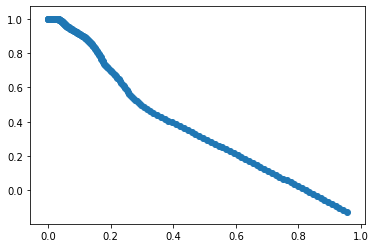

Step 40563, Total reward: 1990, Eps: 0.02713982911434916
Step 40763, Total reward: -200, Eps: 0.02680043775858955
Step 40963, Total reward: 1240, Eps: 0.02646776680194219
Step 41163, Total reward: 1930, Eps: 0.02614168317158877
Step 41309, Total reward: 11264, Eps: 0.02590772663582778
Step 41509, Total reward: -180, Eps: 0.025592732543764936
Step 41709, Total reward: -200, Eps: 0.02528397575262545
Step 41909, Total reward: 1770, Eps: 0.02498133275557609
Step 42109, Total reward: -200, Eps: 0.024684682491382712
Step 42309, Total reward: -200, Eps: 0.02439390629598428
Episode 221 of 300


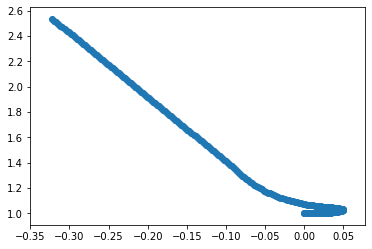

Step 42509, Total reward: -200, Eps: 0.024108887855025535
Step 42709, Total reward: 830, Eps: 0.023829513157329826
Step 42909, Total reward: -200, Eps: 0.023555670449293006
Step 43105, Total reward: 11964, Eps: 0.02329256615337843
Step 43305, Total reward: 2270, Eps: 0.02302935570838382
Step 43505, Total reward: 130, Eps: 0.02277135717939962
Step 43705, Total reward: 1860, Eps: 0.022518467363574213
Step 43905, Total reward: 2330, Eps: 0.022270585101609355
Step 44105, Total reward: 1970, Eps: 0.02202761123729513
Step 44305, Total reward: -200, Eps: 0.021789448577846104
Episode 231 of 300


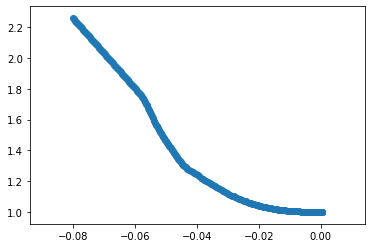

Step 44505, Total reward: 2090, Eps: 0.021556001855022967
Step 44705, Total reward: 1910, Eps: 0.021327177687023913
Step 44905, Total reward: -200, Eps: 0.021102884541130726
Step 45105, Total reward: -200, Eps: 0.020883032697094413
Step 45305, Total reward: 2210, Eps: 0.020667534211245987
Step 45505, Total reward: 2380, Eps: 0.020456302881317737
Step 45705, Total reward: -200, Eps: 0.020249254211961252
Step 45905, Total reward: 1940, Eps: 0.02004630538094809
Step 46105, Total reward: -200, Eps: 0.01984737520603984
Step 46305, Total reward: -140, Eps: 0.01965238411251408
Episode 241 of 300


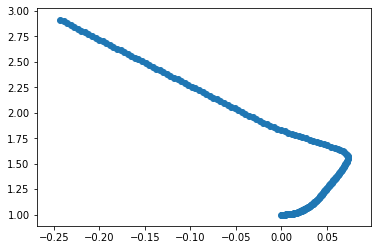

Step 46505, Total reward: -200, Eps: 0.01946125410133351
Step 46705, Total reward: -200, Eps: 0.0192739087179452
Step 46864, Total reward: 11381, Eps: 0.019127619649357115
Step 47064, Total reward: 2270, Eps: 0.018946880670748515
Step 47264, Total reward: -200, Eps: 0.01876972056370155
Step 47464, Total reward: 1900, Eps: 0.01859606846181123
Step 47636, Total reward: 11648, Eps: 0.018449480355846988
Step 47836, Total reward: -200, Eps: 0.01828216943493271
Step 48036, Total reward: -200, Eps: 0.0181181714922228
Step 48236, Total reward: 2030, Eps: 0.017957420926353513
Episode 251 of 300


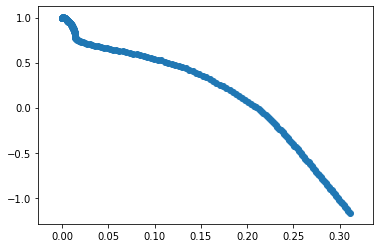

Step 48436, Total reward: 1250, Eps: 0.01779985343495512
Step 48636, Total reward: 2380, Eps: 0.01764540598893015
Step 48836, Total reward: -200, Eps: 0.01749401680724085
Step 49036, Total reward: -200, Eps: 0.01734562533219601
Step 49236, Total reward: 2080, Eps: 0.017200172205227023
Step 49436, Total reward: -200, Eps: 0.017057599243143706
Step 49593, Total reward: 11223, Eps: 0.016947660214630164
Step 49793, Total reward: 2340, Eps: 0.01681008732496661
Step 49993, Total reward: 1960, Eps: 0.016675238561035425
Step 50193, Total reward: 1860, Eps: 0.016543059981533013
Episode 261 of 300


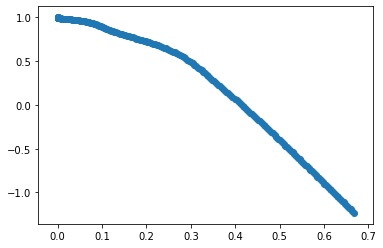

Step 50393, Total reward: 1440, Eps: 0.01641349871326519
Step 50593, Total reward: 1890, Eps: 0.016286502929997115
Step 50793, Total reward: 1980, Eps: 0.016162021831722204
Step 50993, Total reward: 890, Eps: 0.016040005624341366
Step 51193, Total reward: -200, Eps: 0.01592040549974475
Step 51393, Total reward: 2030, Eps: 0.015803173616287816
Step 51593, Total reward: 1810, Eps: 0.015688263079654086
Step 51793, Total reward: 2330, Eps: 0.015575627924096731
Step 51928, Total reward: 11175, Eps: 0.015500862747555749
Step 52073, Total reward: 11285, Eps: 0.01542167573100385
Episode 271 of 300


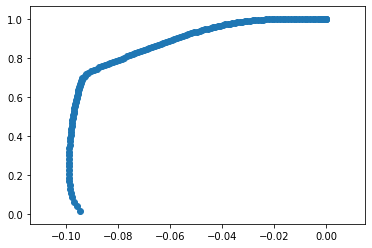

Step 52273, Total reward: 1900, Eps: 0.015314319358629404
Step 52473, Total reward: 1860, Eps: 0.01520908878485695
Step 52673, Total reward: 1880, Eps: 0.01510594191605388
Step 52873, Total reward: 2010, Eps: 0.015004837492097366
Step 53073, Total reward: 1750, Eps: 0.014905735069869745
Step 53189, Total reward: 11074, Eps: 0.014849157328383529
Step 53389, Total reward: 2340, Eps: 0.014753137579937263
Step 53589, Total reward: 1290, Eps: 0.014659019149898988
Step 53789, Total reward: -140, Eps: 0.014566764389641752
Step 53989, Total reward: 2080, Eps: 0.014476336396031384
Episode 281 of 300


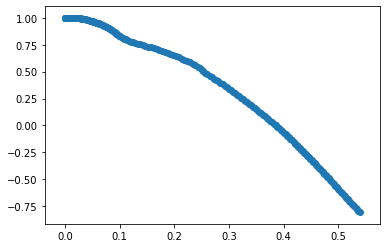

Step 54189, Total reward: 1650, Eps: 0.014387698996664706
Step 54324, Total reward: 11365, Eps: 0.014328863096106027
Step 54524, Total reward: 1850, Eps: 0.014243145863729701
Step 54724, Total reward: 2310, Eps: 0.014159125946274899
Step 54924, Total reward: 1950, Eps: 0.014076769734654361
Step 55032, Total reward: 11172, Eps: 0.014032977525111075
Step 55232, Total reward: 1960, Eps: 0.013953119219589838
Step 55432, Total reward: 1880, Eps: 0.013874842214465393
Step 55632, Total reward: 2120, Eps: 0.01379811519789199
Step 55832, Total reward: 1970, Eps: 0.01372290747803995
Episode 291 of 300


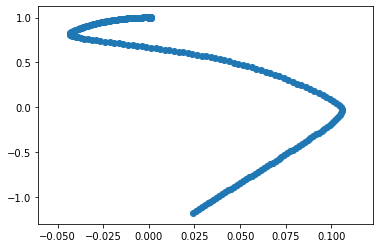

Step 56032, Total reward: 1820, Eps: 0.01364918897081856
Step 56232, Total reward: 1540, Eps: 0.013576930187841995
Step 56382, Total reward: 11480, Eps: 0.013523676635169776
Step 56582, Total reward: -200, Eps: 0.013453903162955427
Step 56782, Total reward: 2460, Eps: 0.013385511298058914
Step 56982, Total reward: 2120, Eps: 0.01331847368282238
Step 57182, Total reward: 1080, Eps: 0.013252763501305878
Step 57382, Total reward: 1600, Eps: 0.013188354468560658
Step 57582, Total reward: 1750, Eps: 0.013125220820114821
Step 57782, Total reward: 740, Eps: 0.0130633373016672


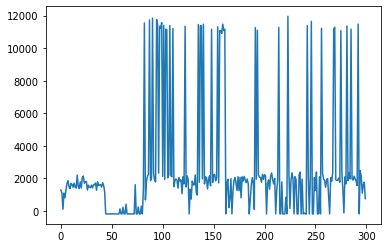

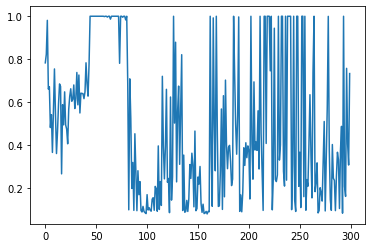

In [115]:
if __name__ == "__main__":
    p1_position = np.array([0, 1]).reshape((2, 1))
    p1_velocity = np.array([1, 1]).reshape((2, 1))
    p1 = Particle(3, 10, initial_position=p1_position,
                  initial_velocity=p1_velocity, exhaust_velocity=100)


    p2_position = np.array([0, 0]).reshape((2, 1))
    p2_velocity = np.array([0, 2]).reshape((2, 1))
    p2 = Particle(1, 50, initial_position=p2_position,
                  initial_velocity=p2_velocity)
    step_size = 0.0001
    particle_list = [p1, p2]
    update_funcs = [gravitaional_pull_from_list(particle_list), zero_update_function]
    env = Scene(particle_list=particle_list, update_functions= update_funcs, step_length=step_size, target=np.zeros((2,1)) )

    num_states = 5
    num_actions = 5

    model = Model(num_states, num_actions, BATCH_SIZE)
    mem = Memory(50000)

    with tf.Session() as sess:
        sess.run(model.var_init)
        gr = GameRunner(sess, model, env, mem, MAX_EPSILON, MIN_EPSILON,
                        LAMBDA, render=False)
        num_episodes = 300
        cnt = 0
        while cnt < num_episodes:
            if cnt % 10 == 0:
                print('Episode {} of {}'.format(cnt+1, num_episodes))
                position_list_x = []
                position_list_y = []
                for p in gr.get_ship_list():
                  position_list_x.append(p[1][0])
                  position_list_y.append(p[1][1])
                plt.scatter(position_list_x, position_list_y)
                plt.show()
            gr.run()
            cnt += 1
        plt.plot(gr.reward_store)
        plt.show()
        plt.close("all")
        plt.plot(gr.max_x_store)
        plt.show()

In [94]:
p1.state_list

[(0, array([[0],
         [5]]), array([[1],
         [1]]), 100)]